# Backend Execution

*What you will learn:*

- what a `Backend` is for;
- what types of `Backend` exist;
- how to choose the best `Backend` for your needs;
- how to execute a `Sequence` on a `Backend` and retrieve the results.

## Introduction

When the time comes to execute a Pulser sequence, there are many options: one can choose to execute it on a QPU or on an emulator, which might happen locally or remotely. All these options are accessible through an unified interface we call a `Backend`. 

This tutorial is a step-by-step guide on how to use the different backends for Pulser sequence execution.

## 1. Choosing the type of backend

Although the backend interface nearly doesn't change between backends, some will unavoidably enforce more restrictions on the sequence being executed or require extra steps. In particular, there are two questions to answer:

1. **Is it local or remote?** Execution on remote backends requires a working remote connection. For now, this is only available through `pulser_pasqal.PasqalCloud`.
2. **Is it a QPU or an Emulator?** For QPU execution, there are extra constraints on the sequence to take into account. Nonetheless, we can still enforce the same constraints when using an Emulator by setting `mimic_qpu=True`.

### 1.1. Starting a remote connection

For remote backend execution, start by ensuring that you have access and start a remote connection. For `PasqalCloud`, we could start one by running:

In [ ]:
from pulser_pasqal import PasqalCloud

connection = PasqalCloud(
    username=USERNAME,  # Your username or email address for the Pasqal Cloud Platform
    project_id=PROJECT_ID,  # The ID of the project associated to your account
    password=PASSWORD,  # The password for your Pasqal Cloud Platform account
)

### 1.2. Preparation for execution on  `QPUBackend`

Sequence execution on a QPU is done through the `QPUBackend`, which is a remote backend. Therefore, it requires a remote backend connection, which should be open from the start due to two additional QPU constraints:

1. The `Device` must be chosen among the options available at the moment, which can be found through `connection.fetch_available_devices()`.
2. If in the chosen device `Device.requires_layout` is `True`, the `Register` must be defined from a register layout:  
    -  If `Device.accepts_new_layouts` is `False`, use one of the register layouts calibrated for the chosen `Device` (found under `Device.calibrated_register_layouts`). Check out [this tutorial](reg_layouts.nblink) for more information on how to define a `Register` from a `RegisterLayout`.
    - Otherwise, we may choose to define our own custom layout or rely on `Register.with_automatic_layout()` to
    give us a register from an automatically generated register layout that fits our desired register while obeying the device constraints. 


On the contrary, execution on emulator backends imposes no further restriction on the device and the register. We will stick to emulator backends in this tutorial, so we will forego the requirements of QPU backends in the following steps.

## 2. Creating the Pulse Sequence

The next step is to create the sequence that we want to execute. Here, we make a sequence with a variable duration combining a Blackman waveform in amplitude and a ramp in detuning. Since it will be executed on an emulator, we can create the register we want and choose an appropriate `Device`.

Since we are also going to run this sequence remotely, we have to use a device that is supported by the cloud. Supported devices can be queried via the `Connection` object.

<div class="alert alert-warning">

Attention
    
This examples uses a [parametrized sequence](paramseqs.nblink), which is only introduced in the *Extended Usage* section.

</div>

In [2]:
connection.fetch_available_devices()

{'FRESNEL_RD': FRESNEL_RD, 'FRESNEL': FRESNEL}

Let us use the `Fresnel` device.

In [3]:
device = connection.fetch_available_devices()["FRESNEL"]

In [4]:
import numpy as np
import pulser
import pulser_simulation

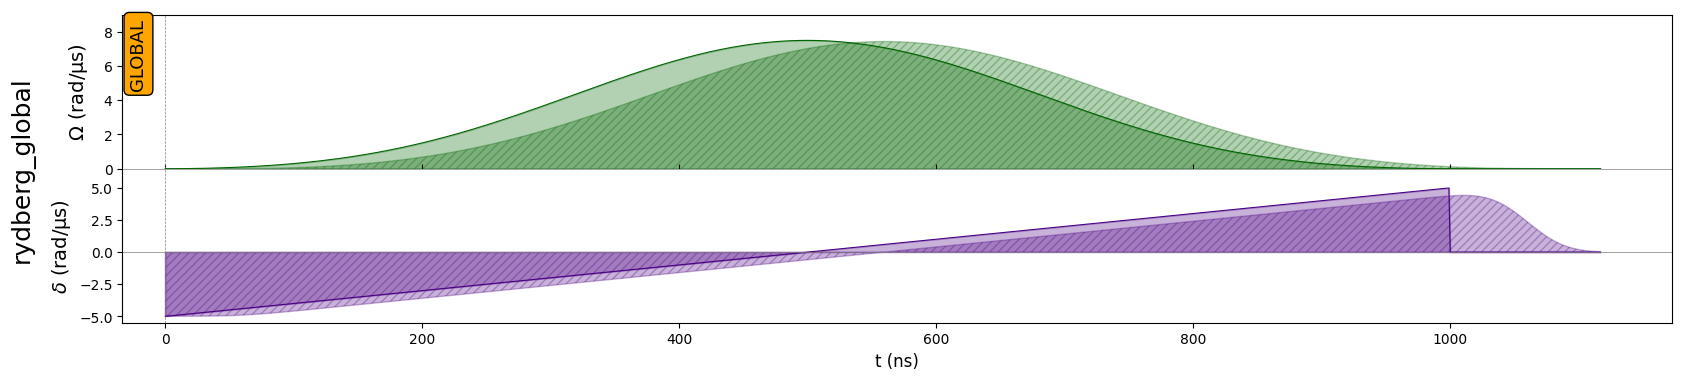

In [5]:
reg = pulser.Register({"q0": (-5, 0), "q1": (5, 0)})

seq = pulser.Sequence(reg, device)
seq.declare_channel("rydberg_global", "rydberg_global")
t = seq.declare_variable("t", dtype=int)

amp_wf = pulser.BlackmanWaveform(t, np.pi)
det_wf = pulser.RampWaveform(t, -5, 5)
seq.add(pulser.Pulse(amp_wf, det_wf, 0), "rydberg_global")

# We build with t=1000 so that we can draw it
seq.build(t=1000).draw()

## 3. Starting the backend

It is now time to select and initialize the backend. Currently, these are the available backends (but bear in mind that the list may grow in the future, and that deprecated backends are not listed):

 - **Local**: 
     - `QutipBackendV2` (from `pulser_simulation`): Uses `QutipEmulator` to emulate the sequence execution locally.
 - **Remote**:
     - `QPUBackend` (from `pulser`): Executes on a QPU through a remote connection.
     - `EmuFreeBackendV2` (from `pulser_pasqal`): Executes the sequence on `QutipBackendV2`, but runs remotely in the cloud. 
     - `SVBackend` (from `emu_sv`): Emulates the sequence execution using a custom-built state vector emulator.
     - `MPSBackend` (from `emu_mps`): Emulates the sequence using a tensor network emulator. 
     - `EmuMPSBackend` (from `pulser_pasqal`): Executes the sequence on `MPSBackend` but run remotely in the cloud.

If the appropriate packages are installed, all backends should be available via the `pulser.backends` module so we don't need to explicitly import them.

Upon creation, all backends require the sequence they will execute. Emulator backends also accept, optionally, a configuration given as an instance of the `EmulationConfig` class. This is a parent class defining a general emulator configuration. Each emulator checks that it only contains supported configuration values, and to ensure that it is filled in correctly there exist subclasses for each emulator, such as `QutipConfig` for `QutipBackendV2`.

A full list of available backends is available in the [backends' docstrings](../apidoc/_autosummary/pulser.backends.rst#module-pulser.backends).

With `QutipBackendV2`, we have free reign over the configuration. In this example, we will:
 
- Change the `sampling_rate`
- Include measurement errors using a custom `NoiseModel`

On the other hand, `QutipBackendV2` does not support parametrized sequences. Since it is running locally, they can always be built externally before being given to the backend. Therefore, we will build the sequence (with `t=2000`) before we give it to the backend.

In [6]:
config = pulser_simulation.QutipConfig(
    sampling_rate=0.1,
    noise_model=pulser.NoiseModel(
        p_false_pos=0.01,
        p_false_neg=0.004,
    ),
    observables=[pulser.backend.StateResult(evaluation_times=[1.0])],
)

qutip_bknd = pulser.backends.QutipBackendV2(seq.build(t=2000), config=config)

<div class="alert alert-info">

The `NoiseModel` class describes the noise of the setup. Read more about simulations with noise [in this tutorial](../noise_model.ipynb).
</div>

Currently, the remote emulator backends are still quite limited in the number of parameters they allow to be changed. Furthermore, different emulators have different default settings, so it's important to start from the correct default configuration. Here's how to do that for the `EmuMPSBackend`:

In [7]:
bitstrings = pulser.backend.BitStrings(evaluation_times=[1.0])
occupation = pulser.backend.Occupation(evaluation_times=[1.0])
emu_mps_config = pulser.backend.EmulationConfig(
    num_gpus_to_use=0, observables=[bitstrings, occupation]
)
emu_free_config = pulser_simulation.QutipConfig(
    observables=[bitstrings, occupation]
)

We will stick to the default configuration for `EmuFreeBackend`, but the process to create a custom configuration would be identical. To know which parameters can be changed, consult the backend's docstring.

In [8]:
free_bknd = pulser.backends.EmuFreeBackendV2(
    seq, connection=connection, config=emu_free_config
)
mps_bknd = pulser.backends.EmuMPSBackend(
    seq, connection=connection, config=emu_mps_config
)

Note also that the remote backends require an open connection upon initialization. This would also be the case for `QPUBackend`.

## 4. Executing the Sequence

Once the backend is created, executing the sequence is always done through the backend's `run()` method.

For the `QutipBackend`, all arguments are optional and are the same as the ones in `QutipEmulator`. On the other hand, remote backends all require `job_params` to be specified. `job_params` are given as a list of dictionaries, each containing the number of runs and the values for the variables of the parametrized sequence (if any). The sequence is then executed with the parameters specified within each entry of `job_params`.

In [9]:
# Local execution, returns the same results as QutipEmulator
qutip_results = qutip_bknd.run()

In [10]:
# Remote execution, requires job_params
job_params = [
    {"runs": 100, "variables": {"t": 1000}},
    {"runs": 50, "variables": {"t": 2000}},
]
free_results = free_bknd.run(job_params=job_params)
mps_results = mps_bknd.run(job_params=job_params)

## 5. Retrieving the Results

For the `QutipBackend` the results are identical to those of `QutipEmulator`: a sequence of individual `QutipResult` objects, one for each evaluation time. As usual we can, for example, get the final state:

In [11]:
qutip_results.state[-1]

QutipState
----------
Eigenstates: ('r', 'g')
Quantum object: dims=[[2, 2], [1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.64677781+0.72942015j]
 [-0.03110523+0.14579561j]
 [-0.03110523+0.14579561j]
 [-0.00110516-0.07194168j]]

For remote backends, the object returned is a `RemoteResults` instance, which uses the connection to fetch the results once they are ready. To check the status of the batch, we can run:

In [16]:
print(free_results.get_batch_status())
print(mps_results.get_batch_status())

BatchStatus.DONE
BatchStatus.DONE


When the batch states shows as `DONE`, the results can be accessed. They are packaged in a `RemoteResults` objects, which will contain one `Results` for each entry in `job_params` in the same order.

In [21]:
free_results.results

(Results(atom_order=('q0', 'q1'), total_duration=1000, _results={UUID('b214aa62-690d-467d-997a-49d18d9dd870'): [{'11': 96, '10': 3, '01': 1}]}, _times={UUID('b214aa62-690d-467d-997a-49d18d9dd870'): [1.0]}, _aggregation_methods={UUID('b214aa62-690d-467d-997a-49d18d9dd870'): <AggregationMethod.BAG_UNION: 3>}, _tagmap={'bitstrings': UUID('b214aa62-690d-467d-997a-49d18d9dd870')}),
 Results(atom_order=('q0', 'q1'), total_duration=2000, _results={UUID('cb863d4a-0320-4c37-a2e2-2d8207708c0b'): [{'11': 50}]}, _times={UUID('cb863d4a-0320-4c37-a2e2-2d8207708c0b'): [1.0]}, _aggregation_methods={UUID('cb863d4a-0320-4c37-a2e2-2d8207708c0b'): <AggregationMethod.BAG_UNION: 3>}, _tagmap={'bitstrings': UUID('cb863d4a-0320-4c37-a2e2-2d8207708c0b')}))

We can check which types of result are present. And if bitstrings are present at the final time, we can inspect them with a dedicated method, in addition to the general mechanism.

In [20]:
print(free_results.results[1].get_result_tags())
print(free_results.results[1].final_bitstrings)
print(free_results.results[1].bitstrings[-1])

['bitstrings']
{'11': 50}
{'11': 50}


Emu MPS will return the requested observables, but also a `statistics` observable that gives information about memory usage and runtime at each time step the emulator took.

In [18]:
print(mps_results.results[1].get_result_tags())
print(mps_results.results[1].statistics[-1])
print(mps_results.results[1].occupation[-1])

['statistics', 'bitstrings', 'occupation']
{'max_bond_dimension': 2, 'memory_footprint': 0.000128, 'RSS': 21.10362, 'duration': 0.6875097751617432}
[0.9725880525085354, 0.9725880525085354]


The same could be done with any `Backend` that implements the new interface, as they all share the same format.

## 6. Alternative user interfaces for using remote backends

Once you have created a Pulser sequence, you can also use specialized Python SDKs to send it for execution:

- the [pasqal-cloud](https://docs.pasqal.cloud/cloud/pasqal-cloud/) Python SDK, developed by PASQAL and used under-the-hood by Pulser's remote backends.
- Azure's Quantum Development Kit (QDK) which you can use by creating an [Azure Quantum workspace](https://learn.microsoft.com/en-gb/azure/quantum/provider-pasqal) directly integrated with PASQAL emulators and QPU.